In [12]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import func4behav as fb
from scipy.stats import lognorm, exponnorm, invgauss
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
from pyddm import Model, Sample, Fittable, Fitted
from pyddm.models import DriftConstant, NoiseConstant, BoundConstant, OverlayNonDecision, ICPointSourceCenter, LossRobustLikelihood
from pyddm.functions import fit_adjust_model, display_model
import pyddm.plot

import imp
imp.reload(fb)

<module 'func4behav' from 'c:\\Users\\Tianyi Zheng\\OneDrive - neuron.t.u-tokyo.ac.jp\\Documents\\zheng\\mywork\\attention_tES\\tes-attention\\processing\\behavior\\func4behav.py'>

In [17]:
all_real = [1, 3, 4, 5, 9, 12, 13, 17, 18]
all_sham = [2, 6, 7, 8, 10, 11, 14, 15, 16]

method1_p = np.ndarray([15,3])
method2_p = np.ndarray([15,3])
method3_p = np.ndarray([15,4])
method4_p = np.ndarray([15,3])
p_mat = [method1_p, method2_p, method3_p, method4_p]

method1_eval = np.ndarray([15,3])
method2_eval = np.ndarray([15,3])
method3_eval = np.ndarray([15,3])
method4_eval = np.ndarray([15,3])
eval_mat = [method1_eval, method2_eval, method3_eval, method4_eval]

case_list = ['all', 'endo', 'exo', 'valid', 'endo valid', 'exo valid', 'invalid', 'endo invalid', 'exo invalid', 'stim left', 'endo stim left', 'endo stim right', 'stim right', 'exo stim left', 'exo stim right']


In [14]:
def make_rt_data(case):
    behavior_compare, experiment = fb.create_allsubs_compare()
    for subject_id in range (10,11):
        behavior_before, behavior_after = fb.load_behavior(subject_id)
        behavior_before, behavior_after = fb.filter_behav(case, behavior_before, behavior_after)
        behavior_compare = fb.allsubs_compare(subject_id, behavior_before, behavior_after, behavior_compare, experiment, verbose=False)

    behavior_compare = behavior_compare.loc[(behavior_compare['response'] == 1) & (behavior_compare['reaction time'] > 0.05) & (behavior_compare['reaction time'] < 1)]
    display(behavior_compare)
    rt_sham = behavior_compare.loc[behavior_compare['Real stimulation'] == 0]
    rt_real = behavior_compare.loc[behavior_compare['Real stimulation'] == 1]

    rt_sham_before = rt_sham.loc[rt_sham['session'] == 'before', 'reaction time'].values
    rt_sham_after = rt_sham.loc[rt_sham['session'] == 'after', 'reaction time'].values
    rt_real_before = rt_real.loc[rt_real['session'] == 'before', 'reaction time'].values
    rt_real_after = rt_real.loc[rt_real['session'] == 'after', 'reaction time'].values

    return rt_sham_before, rt_sham_after, rt_real_before, rt_real_after

In [15]:
# Function to fit a shifted log-normal distribution
def compare_distributions(case, bin_size=50):
    four_data = make_rt_data(case)
    four_data_name = ["Sham before", "Sham after", "Real before", "Real after"]

    fig, axs = plt.subplots(2, 2, figsize=(12, 10)) # Create a 2x2 grid of subplots
    axs = axs.flatten() # Flatten the axes array to make indexing easier

    for i, data in enumerate(four_data):

        mse = np.ndarray([])
        log_L = np.ndarray([])
        AIC = np.ndarray([])

        xmax = 1
        ymax = 80
        bin_edges = np.linspace(0, xmax, bin_size+1)

        # Plot the histogram of the data in the corresponding subplot
        axs[i].hist(data, bins=bin_edges, density=True, alpha=0.4, color='grey', label='Reaction time histogram')

        methods = [fit_and_plot_shift_lognorm, fit_and_plot_exgaussian, fit_and_plot_ddm, fit_and_plot_shift_invgauss]
        for method in methods:
            mse_tmp, log_L_tmp, AIC_tmp = method(data, bin_edges, ax=axs[i]) # Pass the axis to the method
            mse = np.append(mse, mse_tmp)
            log_L = np.append(log_L, log_L_tmp)
            AIC = np.append(AIC, AIC_tmp)
        
        axs[i].set_title(case + ": " + four_data_name[i]+ ", " + str(bin_size))
        axs[i].set_xlabel('Reaction Time (s)')
        axs[i].set_xlim(0, xmax)
        axs[i].set_ylabel('Probability Density')
        axs[i].legend()

    plt.show()
    return True


def log_likelihood(data, x, pdf_x):
    # evaluate: close to 0 is good
    pdf_data = np.interp(np.sort(data), x, pdf_x)
    epsilon = 1e-10  # Small constant to avoid taking log of zero
    log_L = np.sum(np.log(pdf_data + epsilon))
    return log_L

def akaike(k, log_L):
    # evaluate: smaller is better
    return 2 * k - 2 * log_L

def shifted_lognorm(x, s, scale, loc):
    return lognorm.pdf(x, s, loc=loc, scale=scale)


def fit_and_plot_shift_lognorm(data, bin_edges, ax=None):

    # Estimate initial parameters
    shape, loc, scale = lognorm.fit(data)
    params, _ = curve_fit(shifted_lognorm, np.sort(data), lognorm.pdf(np.sort(data), shape, loc=loc, scale=scale), p0=[shape, scale, loc])
    # Generate x values
    x = np.linspace(0, bin_edges[-1], 1000)
    # Get the fitted distribution values
    fitted_values = shifted_lognorm(x, *params)
    # Compute histogram
    hist, bin_edges = np.histogram(data, bins=bin_edges, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    # Interpolate fitted values at the bin centers
    fitted_values_interpolated = np.interp(bin_centers, x, fitted_values)
    # Compute the mean squared error
    mse = mean_squared_error(hist, fitted_values_interpolated)
    log_L = log_likelihood(data, x, fitted_values)
    AIC = akaike(3,log_L)
    # Plot the fitted shifted log-normal distribution
    ax.plot(x, fitted_values, 'y--', label=f"Shifted log-normal, MSE={mse:.3f},\n L={log_L:.1f}, AIC={AIC:.1f}")

    return mse, log_L, AIC


def fit_and_plot_exgaussian(data, bin_edges, ax=None):
    # Fit Ex-Gaussian distribution
    K, loc, scale = exponnorm.fit(data)
    # Generate x values
    x = np.linspace(0, bin_edges[-1], 1000)
    # Compute the Ex-Gaussian PDF
    fitted_values = exponnorm.pdf(x, K, loc, scale)
    # Compute histogram
    hist, bin_edges = np.histogram(data, bins=bin_edges, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    # Interpolate fitted values at the bin centers
    fitted_values_interpolated = np.interp(bin_centers, x, fitted_values)
    # Compute the mean squared error
    mse = mean_squared_error(hist, fitted_values_interpolated)
    log_L = log_likelihood(data, x, fitted_values)
    AIC = akaike(3,log_L)
    # Plot the fitted Ex-Gaussian distribution
    ax.plot(x, fitted_values, 'g--', label=f"Ex-Gaussian, MSE={mse:.3f},\n L={log_L:.1f}, AIC={AIC:.1f}")

    return mse, log_L, AIC


def fit_and_plot_ddm(data, bin_edges, ax=None):
    rt = data.copy()
    corr = np.ones(rt.shape[0])
    M = np.column_stack((rt, corr))

    ddm_data = Sample.from_numpy_array(M, [])

    model_fit = Model(name='My data (fitted)',
                    drift=DriftConstant(drift=Fittable(minval=1, maxval=10)),
                    noise=NoiseConstant(noise=Fittable(minval=0.5, maxval=5)),
                    bound=BoundConstant(B=Fittable(minval=0.5, maxval=5)),
                    overlay=OverlayNonDecision(nondectime=Fittable(minval=0.01, maxval=0.3)),
                    dx=.001, dt=.01, T_dur=2)
    fit_adjust_model(ddm_data, model_fit,
                    fitting_method="differential_evolution",
                    lossfunction=LossRobustLikelihood, verbose=False)
    # Get the fitted parameters
    params = model_fit.parameters()
    prediction = model_fit.solve()
    # histogram
    # Compute histogram
    hist, bin_edges = np.histogram(rt, bins=bin_edges, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    # Interpolate fitted values at the bin centers
    fitted_values_interpolated = np.interp(bin_centers, prediction.t_domain, prediction.pdf("correct"))

    # Compute the mean squared error
    mse = mean_squared_error(hist, fitted_values_interpolated)
    log_L = log_likelihood(data, prediction.t_domain, prediction.pdf("correct"))
    AIC = akaike(4,log_L)

    ax.plot(prediction.t_domain, prediction.pdf("correct"), 'r--',label=f"DDM, MSE={mse:.3f},\n L={log_L:.1f}, AIC={AIC:.1f}")

    return mse, log_L, AIC


def shifted_invgauss(x, mu, loc, scale):
    return invgauss.pdf(x, mu, loc=loc, scale=scale)


def fit_and_plot_shift_invgauss(data, bin_edges, ax=None):
    # Estimate initial parameters
    mu, loc, scale = invgauss.fit(data)
    # Generate x values
    x = np.linspace(0, bin_edges[-1], 1000)
    # Get the fitted distribution values
    fitted_values = shifted_invgauss(x, mu, loc, scale)
    # Compute histogram
    hist, bin_edges = np.histogram(data, bins=bin_edges, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    # Interpolate fitted values at the bin centers
    fitted_values_interpolated = np.interp(bin_centers, x, fitted_values)
    # Compute the mean squared error
    mse = mean_squared_error(hist, fitted_values_interpolated)
    # Define the log-likelihood computation
    log_L = log_likelihood(data, x, fitted_values)
    AIC = akaike(3,log_L)
    # Plot the fitted shifted inverse Gaussian distribution
    ax.plot(x, fitted_values, 'c--', label=f"Shifted InvGauss, MSE={mse:.3f},\n L={log_L:.1f}, AIC={AIC:.1f}")

    return mse, log_L, AIC

,subject id,trial,Real stimulation,session,type,cue,valid,ICS,stim,response,reaction time
0,10,1,0,before,1,-1,1,1.0,-1,1,0.32844
1,10,2,0,before,2,-1,1,0.5,-1,1,0.26835
2,10,3,0,before,1,-1,-1,0.5,1,1,0.64021
3,10,4,0,before,1,-1,-1,1.0,1,1,0.37665
4,10,5,0,before,2,-1,1,0.5,-1,1,0.26180
...,...,...,...,...,...,...,...,...,...,...,...
235,10,116,0,after,1,-1,-1,0.5,1,1,0.36499
236,10,117,0,after,2,1,1,0.5,1,1,0.25792
237,10,118,0,after,1,-1,-1,0.5,1,1,0.24594
238,10,119,0,after,2,1,1,1.0,1,1,0.24153


Info: Params [7.64597736 1.05417538 2.03464189 0.01773842] gave -144.03504194766506
Info: Params [9.4603035  1.0273741  2.37892535 0.0164084 ] gave -179.96847601839082


FloatingPointError: invalid value encountered in divide

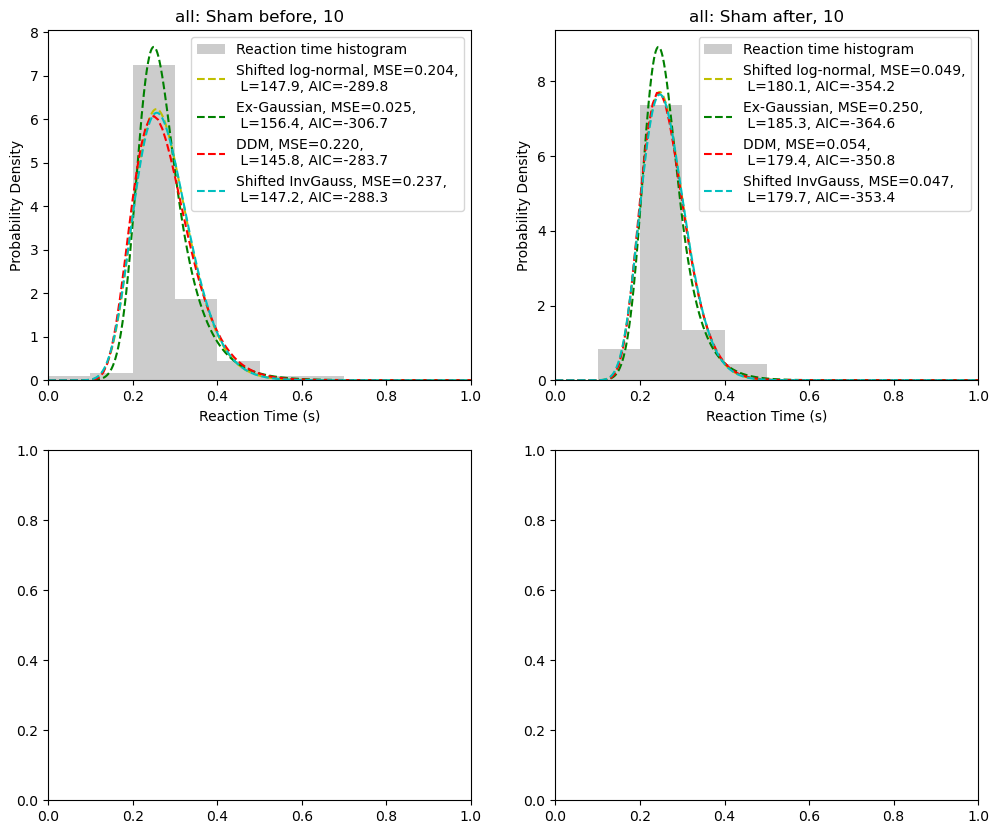

In [16]:
compare_distributions('all', bin_size=10)

In [ ]:
# pyddm.plot.model_gui(model=model_fit, sample=data)